<a target="_blank" href="https://colab.research.google.com/github/alejandrogtz/cccs630-fall2023/blob/main/module04/agent-based_applications.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Applications of Agent-Based Simulations

## Introduction

In this module, we will examine an application of agent-based simulations in the context of a transportation system and analyze how traffic jams are formed.

Agent-based simulations allow testing different changes to the agents, scenarios, and conditions of a system. In the case of transportation systems, it is possible to study changes to the roads, drivers, traffic laws, and roadblocks, for example. Depending on the objective of a study, these changes can then be quantified in terms of CO2 emissions, transportation time, number of accidents, maximum number of vehicles, etc.

In preparation for the interaction part, please read the following Wikipedia entry about one of the longest traffic jams ever recorded.

https://en.wikipedia.org/wiki/China_National_Highway_110_traffic_jam

## Concepts

You will find a list of important concepts we will review in the module below.

- Abstraction
- Assumptions
- Traffic jams
- Transportation systems
- Random noise

## Interaction

There are many applications of agent-based simulations. Some of these include:

- Simulate the spread of infectious diseases
- Simulate economic systems
- Simulate transportation systems

Creating a model requires deciding what to include or not based on its purpose. Including too many details about the system and its elements can make the modelling challenging. On the other side, missing important aspects can lead to not being able to capture the phenomena we want to study. Suppose we want to model a transformation system; one must decide if it is necessary to consider the drivers' emotions and how it affects their driving, or we can assume all drivers will behave in the same way.

Additionally, we must define the appropriate resolution level or abstraction we should use as the reference point for our model. 

In this interaction, we will use an agent-based simulation to study traffic jams. The objective of the simulation is to understand how the number of vehicles and acceleration decisions can lead to traffic jams. For this objective, we will create an environment where our agents, representing vehicles and drivers, move. 

The code of this simulation is based on the work of Allen Downey, as it appears in the book Think Complexity, 2nd edition (https://thinkcomplex.com) and published under the MIT License (http://opensource.org/licenses/MIT).

In the previous modules, our agents occupied single discrete squares in 1D spaces (arrays) or 2D spaces (matrices, checkboards), but we can arrange our agents in other structures like networks, continuous spaces, etc. For this simulation, we will change the environment format. We will assume a continuous one-dimensional circular space that represents a single-line road with no space for passing, named Highway in the code below, with n number of drivers. 

The class Driver defines the operation of the agents, represented by blue squares in the simulation. Agents have a single decision to make during the simulation: choose the acceleration of their vehicles. Their default behaviour is to accelerate to the maximum (1 mile/hr), until they get blocked by the car immediately ahead. When this occurs, drivers have to break to avoid a collision. The speed of the vehicle will be set to 0, the simulation will show a triangle, and it will be registered as a crash.    

During the simulation, random noise will affect the vehicle speed. This noise represents the imperfection in the conditions (distracted driver, mechanical problems, etc.).
   
### Assumptions

Assumptions are basic conditions or premises that are considered to be true for the purpose of the model or conducting an analysis. They simplify the conditions of the real-world system to make it more manageable for study. 

For example, these are some of the assumptions made in this traffic model:

- Single-line road.
- Vehicles can't be passed.
- Vehicles can only go forward.
- Vehicles are initially positioned equally spaced across the road.
- Vehicles have an initial speed of 4 miles/hr (6.437 km/hr).
- Vehicles have a maximum speed of 40 miles/hr (64.37 km/hr).
- The maximum acceleration is 1 mile/hr and the minimum is -10 miles/hr.
- Random noise can be added to represent different driving conditions.
- Collisions (indicated with a triangle during the simulation) cause vehicles to stop (speed = 0).
- The number of vehicles is kept constant during the simulation.

### Instructions

- Simulate the system assuming a low number of vehicles (<=10 vehicles) and no random noise (eps = 0) and document your findings.
- Simulate the system assuming a low number of vehicles (<=10 vehicles) and random noise (eps = 0.01) and document your findings.
- Simulate the system assuming an intermediate number of vehicles (>10 and <=25 vehicles) and random noise (eps = 0.01), and document your findings.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
!git clone https://github.com/alejandrogtz/cccs630-fall2023

'git' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
from importlib.machinery import SourceFileLoader

In [4]:
utils = SourceFileLoader('utils', '/content/cccs630-fall2023/module04/utils.py').load_module()

FileNotFoundError: [Errno 2] No such file or directory: '/content/cccs630-fall2023/module04/utils.py'

In [7]:
Cell2D = SourceFileLoader('Cell2D', '/content/cccs630-fall2023/module04/Cell2D.py').load_module()

FileNotFoundError: [Errno 2] No such file or directory: '/content/cccs630-fall2023/module04/Cell2D.py'

In [8]:
from utils import decorate, savefig

In [9]:
from Cell2D import Cell2D

In [10]:
np.random.seed(1) # Sets the random values.

In [11]:
class Driver:
    
    def __init__(self, loc, driver_id, speed=4):
        self.start = loc
        self.loc = loc # Position on track, in miles.
        self.speed = speed # Speed in miles per hour.
        self.driver_id = driver_id
        
    def choose_acceleration(self, dist):
        return (1) # Increases speed by 1 mile/hr.
    
    def read_driver_id(self):
        return self.driver_id
    
    def set_odometer(self):
        self.start = self.loc
        
    def read_odometer(self):
        return self.loc - self.start
    
    def read_speedometer(self):
        return self.speed

In [12]:
class Highway(Cell2D):
    
    max_acc = 1
    min_acc = -10
    speed_limit = 40
    driver_id_log = []
    location_log = []
    speed_log = []
    crash_log = []
    
    def __init__(self, n=10, length=1000, eps=0, constructor=Driver):
        #n: number of drivers
        #constructor: function used to instantiate drivers

        self.length = length # Length of the track.
        self.eps = eps # Variability in speed.
        self.crashes = 0

        locs = np.linspace(0, length, n, endpoint=False) # Evenly spaced numbers over a specified interval.
         
        self.drivers = []
        driver_id = 0
        for loc in locs:
            # Creates the drivers.
            self.drivers.append(constructor(loc,driver_id))
            driver_id += 1    
    
        # And link them up.
        for i in range(n):
            j = (i+1) % n
            self.drivers[i].next = self.drivers[j]
            
    def step(self):
        # Perform one time step.
        for driver in self.drivers:
            self.move(driver)
    
    # Updates `driver`
    def move(self, driver): 
        
        dist = self.distance(driver) # Get the distance to the next driver.
        acc = driver.choose_acceleration(dist) # Let the driver choose the acceleration.
        acc = min(acc, self.max_acc)
        acc = max(acc, self.min_acc)
        speed = driver.speed + acc
        
        # Add random noise to speed.
        speed *= np.random.uniform(1-self.eps, 1+self.eps)
        
        # Keep it nonnegative and under the speed limit.
        speed = max(speed, 0)
        speed = min(speed, self.speed_limit)
        
        # If current speed would collide with next driver, stop.
        crash = 0
        if speed > dist:
            speed = 0
            crash = 1
            self.crashes += 1
        
        # Update speed and loc.
        driver.speed = speed
        driver.loc += speed
    
        self.driver_id_log.append(driver.driver_id)
        self.location_log.append(driver.loc)
        self.speed_log.append(driver.speed)
        self.crash_log.append(crash)
            
    # Distance from `driver` to next driver.
    def distance(self, driver):
      
        dist = driver.next.loc - driver.loc
        # Fix wraparound
        if dist < 0:
            dist += self.length
        
        return dist
    
    def set_odometers(self):
        return [driver.set_odometer()
                for driver in self.drivers] 
    
    def read_odometers(self):
        return np.mean([driver.read_odometer()
                        for driver in self.drivers])
    
    # Draws the drivers and shows collisions.
    def draw(self):
        
        drivers = self.drivers
        xs, ys = self.get_coords(drivers)
        plt.plot(xs, ys, 'bs', markersize=10, alpha=0.7)
        
        stopped = [driver for driver in self.drivers 
                  if driver.speed==0]
        xs, ys = self.get_coords(stopped, r=0.8)
        plt.plot(xs, ys, 'r^', markersize=12, alpha=0.7)
        
        plt.axis('off')
        plt.axis('equal')
        plt.xlim([-1.05, 1.05])
        plt.ylim([-1.05, 1.05])

    # Gets the coordinates of the drivers. Transforms from (row, col) to (x, y). 
    def get_coords(self, drivers, r=1):
        # r: radius of the circle
        
        locs = np.array([driver.loc for driver in drivers])
        locs *= 2 * np.pi / self.length
        xs = r * np.cos(locs)
        ys = r * np.sin(locs)
        return xs, ys # returns tuple of sequences, (xs, ys)
    
    # Sends the simulation data to an Excel file.
    def export_log(self): 
        log = {
                'Driver_ID':self.driver_id_log,
                'Speed' :self.speed_log,
                'Location':self.location_log,
                'Crash':self.crash_log,
                }
        df = pd.DataFrame(log)
        df.to_excel('log.xlsx', index=True, header=True)

In [13]:
# Function to explore the relationship between eps and average speed.
def run_simulation(eps, constructor=Driver, iters=100):
    res = []
    for n in range(5, 100, 5): # range function = range(start, stop, step) 
        
        highway = Highway(n, eps=eps, constructor=constructor)
        for i in range(iters):
            highway.step()

        highway.set_odometers()
        for i in range(iters):
            highway.step()

        res.append((n, highway.read_odometers() / iters))
    
    return np.transpose(res)

In [18]:
"""
Enter the number of vehicles and the random noise level.
"""
vehicles = 20
eps = 0.1

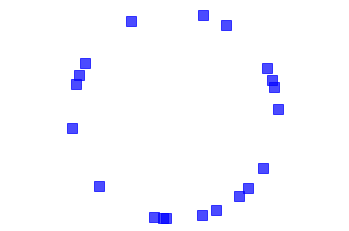

In [19]:
# Run the simulation.
highway = Highway(vehicles, eps=eps) # The first parameter is the number of drivers; the second is the amount of random noise.
# Create the animation.
highway.animate(frames=100, interval=0.2)

In [16]:
"""
Optional step. Exports the simulation data to Excel. Only works for one simulation.
"""
highway.export_log()

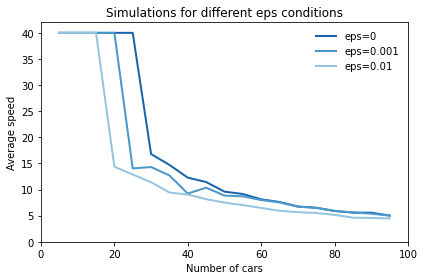

In [17]:
# Generate the figures for different eps conditions.
from utils import set_palette
set_palette('Blues', 4, reverse=True)

for eps in [0.0, 0.001, 0.01]:
    xs, ys = run_simulation(eps)
    plt.plot(xs, ys, label='eps=%g' % eps)
    
decorate(xlabel='Number of cars',
                 ylabel='Average speed',
                 title='Simulations for different eps conditions',
                 xlim=[0, 100], ylim=[0, 42])

## Assignment 

### Conceptual Option

Review the model and simulation covered in this module (assumptions, initial conditions, behaviours, structure, etc.). 
Collect information about the roads, driving behaviour, maximum and minimum speeds, traffic jams, etc., in Canada. 
Supported by the collected data and your experience, describe the adjustments and improvements you recommend adding to the model and the simulation if you would like to study traffic jams in the context of Canada. 

Reference the consulted sources using the APA format. Please submit a 2-3 page Word document with your results.

### Hands-on Option

The code section below creates three new classes and runs a loop to create a graph with the simulation results. The new classes `BetterDriver#` inherits from `Driver` and overrides `choose_acceleration`. The classes have the purpose of defining better driving rules than the basic implementation in `Driver` that only increases speed by 1 mile/hr, as implemented in the code above. 

The loop runs simulations with `Driver` and the `BetterDriver#`, and plots average speed as a function of the number of cars. The plot uses the area under the curves as a way to quantify the effect of driving behaviour on average speed over a range of densities.

The method `choose_acceleration` receives the parameter `dist` that contains the distance to the next car and has access to the class attributes, like speed, via the variable `self.speed`. The minimum and maximum acceleration are -10 miles/hr and 1 mile/hr, the maximum speed is 40 miles/hr, and the `eps` is 0.

For example, the provided `BetterDriverA` class is a little better in the sense that it keeps traffic moving smoothly at medium densities. However:
* At high densities, it has almost no effect, and

* At low densities, it is substantially worse.

As a result, the total area under the curve is smaller.

<b>Your objective is to design and code three `choose_acceleration` methods that try to maximize the area under the curve and analyze the simulation results.</b> Note that there is only a small penalty (1/10) if you can't find a method to maximize the area under the curve. Please submit your best methods in a Jupyter notebook and your analysis in a 1-2 page Word document.

In [172]:
class BetterDriver1(Driver):

    def choose_acceleration(self, dist):
        """
        Write your formulas and rules below.
        """
        if self.speed < 20:
            return 1
        else:
            return 0

In [173]:
class BetterDriver2(Driver):
    
    def choose_acceleration(self, dist):
        """
        Write your formulas and rules below.
        """
        return 0

In [174]:
class BetterDriver3(Driver):
    
    def choose_acceleration(self, dist):
        """
        Write your formulas and rules below.
        """
        return 0

Driver Total Area Under the Curve =  1512.925
BetterDriver1 Total Area Under the Curve =  1238.725
BetterDriver2 Total Area Under the Curve =  360.0
BetterDriver3 Total Area Under the Curve =  360.0


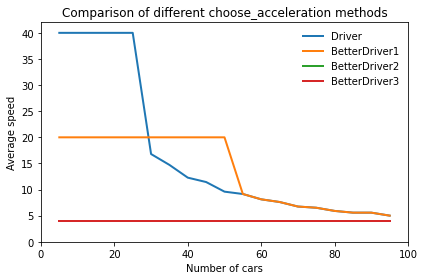

In [175]:
from scipy.integrate import trapezoid

for constructor in [Driver, BetterDriver1,BetterDriver2,BetterDriver3]:
    xs, ys = run_simulation(eps=0.0, constructor=constructor)
    plt.plot(xs, ys, label=constructor.__name__)
    print(constructor.__name__, 'Total Area Under the Curve = ' , trapezoid(ys, xs))
    
decorate(title='Comparison of different choose_acceleration methods',
    xlabel='Number of cars',
    ylabel='Average speed',
    xlim=[0, 100], ylim=[0, 42])

## Recommended Readings

Once you have completed the interaction portion of the module, please read the following recommended reading.

- Bernhardt, K., (2007). Agent-Based Modeling in Transportation. Transportation Research Circular, E-C113, 72-80. https://www.trb.org/Publications/Blurbs/158428.aspx

## Optional Readings

You will find additional resources in case you would like to continue exploring the topics covered in this module below.

- Chapter 10 - Herds, Flocks, and Traffic Jams. Downey, A. (2018). Think complexity: Complexity science and computational modeling (Second). O’Reilly Media. https://mcgill.on.worldcat.org/oclc/1043913738